In [5]:
import os
import shutil
import zipfile
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from datetime import datetime

# ✅ 디바이스 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ✅ 기존 파일/디렉토리 제거
for folder in ['/content/Dataset/', '/content/train/', '/content/valid/', '/content/test/']:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# ✅ 다크스 해제
with zipfile.ZipFile('/content/dataset1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset')

# ✅ 프로젝트 파일 경로
blocked_path = '/content/Dataset/Dataset/Blocked'
free_path = '/content/Dataset/Dataset/Free'
train_dir = '/content/train'
valid_dir = '/content/valid'
test_dir = '/content/test'
classes = ['Blocked', 'Free']

# ✅ 포부 생성
for base_dir in [train_dir, valid_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

# ✅ 데이터 분할 기능함수
def split_and_copy():
    def split_copy(file_list, src, cls):
        file_list = [f for f in file_list if os.path.isfile(os.path.join(src, f))]  # 수정한 바로 구문
        train, temp = train_test_split(file_list, test_size=0.3, random_state=42)
        valid, test = train_test_split(temp, test_size=0.5, random_state=42)
        for f in train:
            shutil.copy(os.path.join(src, f), os.path.join(train_dir, cls, f))
        for f in valid:
            shutil.copy(os.path.join(src, f), os.path.join(valid_dir, cls, f))
        for f in test:
            shutil.copy(os.path.join(src, f), os.path.join(test_dir, cls, f))

    split_copy(os.listdir(blocked_path), blocked_path, 'Blocked')
    split_copy(os.listdir(free_path), free_path, 'Free')

split_and_copy()

# ✅ 강화된 전처리 (Augmentation)
t_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
])

t_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ✅ 데이터세트 & 로딩
train_dataset = datasets.ImageFolder(train_dir, t_train)
valid_dataset = datasets.ImageFolder(valid_dir, t_val)
test_dataset = datasets.ImageFolder(test_dir, t_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ✅ MobileNetV2 구조 & classifier 교체
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)
model = model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ 학습//\uud3c9가 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in dataloader:
        x, y = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(x)
        loss = loss_function(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / len(dataloader), 100 * correct / total

def model_evaluate(dataloader, model, loss_function):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            x, y = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(x)
            loss = loss_function(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(dataloader), 100 * correct / total

def model_test(dataloader, model, loss_function):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            x, y = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(x)
            loss = loss_function(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
    print(f"\nTest Accuracy: {100 * correct / total:.2f}%")
    print(f"Test Loss    : {total_loss / len(dataloader):.4f}\n")


Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 148MB/s]


In [7]:
# ✅ 학습 룰루
EPOCHS = 100
BEST_MODEL_PATH = 'best_model_v2.pth'
best_val_loss = float('inf')
patience = 5
early_stop_counter = 0

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

start_time = datetime.now()

for epoch in range(EPOCHS):
    train_loss, train_acc = model_train(train_loader, model, loss_function, optimizer)
    val_loss, val_acc = model_evaluate(valid_loader, model, loss_function)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"[Epoch {epoch+1:03}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("\nEarly stopping triggered.")
            break

print(f"\nTraining completed in: {datetime.now() - start_time}")

[Epoch 001] Train Loss: 0.6626 | Train Acc: 62.21% || Val Loss: 0.6826 | Val Acc: 45.95%
[Epoch 002] Train Loss: 0.6052 | Train Acc: 70.93% || Val Loss: 0.6396 | Val Acc: 64.86%
[Epoch 003] Train Loss: 0.5578 | Train Acc: 79.07% || Val Loss: 0.5985 | Val Acc: 75.68%
[Epoch 004] Train Loss: 0.5827 | Train Acc: 74.42% || Val Loss: 0.5705 | Val Acc: 83.78%
[Epoch 005] Train Loss: 0.5278 | Train Acc: 79.65% || Val Loss: 0.5346 | Val Acc: 83.78%
[Epoch 006] Train Loss: 0.4627 | Train Acc: 90.70% || Val Loss: 0.5152 | Val Acc: 86.49%
[Epoch 007] Train Loss: 0.4758 | Train Acc: 84.88% || Val Loss: 0.4800 | Val Acc: 86.49%
[Epoch 008] Train Loss: 0.4510 | Train Acc: 88.95% || Val Loss: 0.4624 | Val Acc: 89.19%
[Epoch 009] Train Loss: 0.4279 | Train Acc: 90.70% || Val Loss: 0.4493 | Val Acc: 91.89%
[Epoch 010] Train Loss: 0.3785 | Train Acc: 94.19% || Val Loss: 0.4352 | Val Acc: 89.19%
[Epoch 011] Train Loss: 0.4141 | Train Acc: 88.37% || Val Loss: 0.4108 | Val Acc: 89.19%
[Epoch 012] Train Los


Test Accuracy: 100.00%
Test Loss    : 0.0615



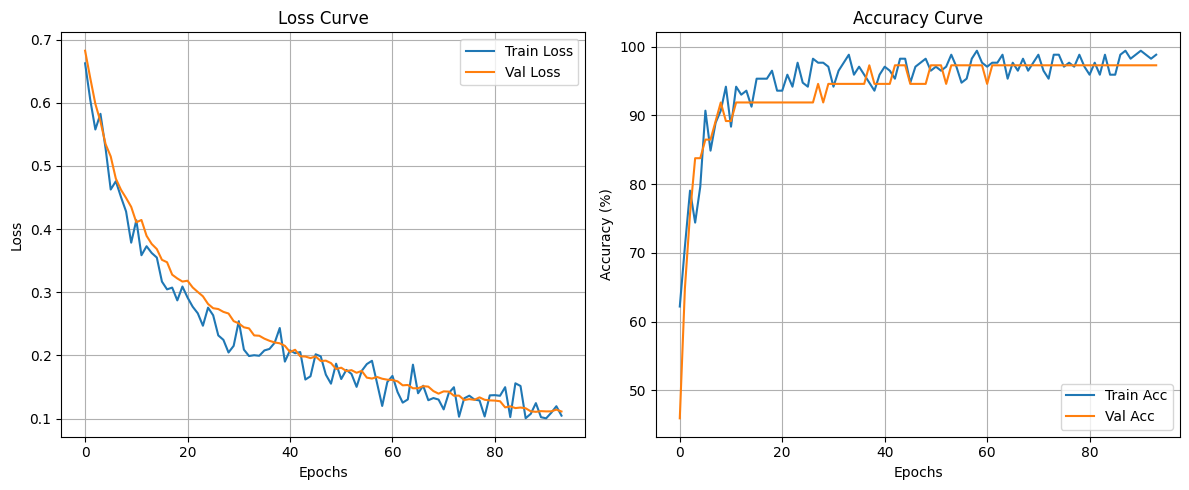

In [8]:
# ✅ 테스트 수행
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model_test(test_loader, model, loss_function)

# ✅ 시간 관련 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# ✅ 이미지 불러오기
image_path = "/content/test/Blocked/111_2025-04-17_13-37-39.jpg"  # <-- 여기에 테스트할 이미지 경로 지정
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# ✅ 추론
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1)
    predicted = torch.argmax(probs, dim=1).item()

# ✅ 클래스 라벨
labels = ["Blocked (패드 있음)", "Free (패드 없음)"]

# ✅ 결과 출력
print(f"🔍 Blocked 확률: {probs[0][0].item():.4f}")
print(f"🔍 Free 확률   : {probs[0][1].item():.4f}")
print(f"✅ 예측 결과   : {labels[predicted]}")


🔍 Blocked 확률: 0.7726
🔍 Free 확률   : 0.2274
✅ 예측 결과   : Blocked (패드 있음)
